In [1]:
import numpy as np
import cv2
from PIL import Image
import socket
# import shutil
# from skimage import io

class State:
    def __init__(self, state_data):
        self.state_data = np.asarray(state_data)
  
    def process_state(self):
        pass
  
    def get_batch_tensor(self):
        holder = np.asarray(self.state_data)
        holder.reshape((1, ) + holder.shape)
        return holder
  
    def get_individual_tensor(self):
        return np.asarray(self.state_data)

    def get_shape(self):
        return self.state_data.shape
  
    def display(self):
        print(self.state_data)
        
# ------------------------------------

class Frame(State):
    def __init__(self, state_data, crop_factor=None, destination_size=None, vert_cent=0.5):
        State.__init__(self, state_data)
#         self.state_data = self.process_state(crop_factor, vert_cent, destination_shape)
        self.state_data = self.process_state([0.7, 1.0], 0.7, (128,64))
  
    def process_state(self, crop_factor, vert_cent, destination_shape):
        """
        Does all the processing of the frame using the helper functions
        """
        frame = self.crop_frame(self.state_data, crop_factor, vert_cent)
        frame = self.normalise_frame(frame)
        frame = self.gray_scale(frame) # cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        assert len(frame.shape) == 2
        frame = self.downsample_frame(frame, destination_shape)
        return frame

  
    def gray_scale(self, frame, gray_scale_factor=[0.3, 0.3, 0.3]):
        frame = np.dot(frame, np.asarray(gray_scale_factor))
        return frame

    def normalise_frame(self, frame):
        frame = frame.astype('float32') / 255.0
        return frame
  
    def downsample_frame(self, frame, destination_shape):
        """
        downsamples the frame. decreases the resolution
        """
        frame = cv2.resize(np.asarray(frame), dsize=destination_shape, interpolation=cv2.INTER_CUBIC)
        return frame
  
    def crop_frame(self, frame, crop_factor, vert_cent):
        """
        input is the frame
        output is the cropped frame
        crop_factor is the ratio at which you want to crop the height and width(0.8, 0.8)
        cent is the ratio at which the centre of the cropped frame should be
        """
        if crop_factor is None:
          return frame
    
        height_factor = int((crop_factor[0]*frame.shape[0]) // 2)
        width_factor = int((crop_factor[1]*frame.shape[1]) // 2)
        vert_cent = int(frame.shape[0]*vert_cent)
        width_cent = int(frame.shape[1]*0.5)

        frame = frame[vert_cent - height_factor: vert_cent + height_factor, 
                      width_cent - width_factor: width_cent + width_factor]
        return frame

# ------------------------------------
class DataBuffer:
    """
    Keeps track of n latest states 
    """
  
    def __init__(self, size=1):
        self.buffer = []
        self.size = size

    def get_input_tensor(self, in_batch=True):
        arr = np.array(self.buffer)
        if self.size == 1 or in_batch:
            return arr
        else:
            return arr.reshape((1, ) + arr.shape)
    
    def get_input_shape(self):
        return np.asarray(self.current_state[0]).shape

    def assign_to_buffer(self, state):
        if isinstance(state, State):
            state = state.get_individual_tensor()
        if len(self.buffer) >= self.size:
            self.buffer.pop(0)
        self.buffer.append(state)
        
# ------------------------------------

class FrameBuffer(DataBuffer):
    def __init__(self, size = 4):
        DataBuffer.__init__(self, size=size)
    
    def get_input_shape(self):
        return self.get_input_tensor().shape
  
    def get_input_tensor(self, in_batch=True):
        temp = np.array(self.buffer)
        return  temp.transpose((1, 2, 0))
    
    def assign_to_buffer(self, state):
        if isinstance(state, State):
            state = state.get_individual_tensor()
        # if buffer not initialised
        if len(self.buffer) == 0:
            self.buffer = [state]
            return

        if len(self.buffer) >= self.size:
            self.buffer.pop(0)
        
        self.buffer.append(state)

In [2]:
from pathlib import Path
import os
import os.path
import random

class EnvironmentWrapper:
    
    def __init__(self):
        
        
        # initialise comms with the simulator here
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM) # initialise the socket
        # connect to localhost, port 2345 
        self.sock.bind(("127.0.0.1", 4444))
        self.sock.listen(1)
        print("Waiting to connect to Simulator...")
        self.clientsocket, _ = self.sock.accept() # connect to simulator [BLOCKING]
        print("Connected to simulator!")
        # =========================================
        
        
        # initialising frame buffer
        self.buffer_size = 4 # could change this 
        
         # this is the FrameBuffer that keeps track of the latest frames.
         #initialising the frame buffer by just giving it multiple copies of the same starting frame
        # =========================================
        
        self.current_state = None
        
        self.current_buffer = None
        
        self.prev_dist = 0
        
        self.time_steps = 0
        
        self.done = False
        
        self.max_time_steps_per_episode = 500 #change this based on the enviorment
        
        # initialise buffer
        self.current_buffer = FrameBuffer(size = self.buffer_size)
        
        # =========================================
        
        
        # Create target directory if it doesn't exist
       
        parent_path = os.path.abspath(os.path.join("", os.pardir))
        self.final_path = parent_path + "/simulation/Screenshots"
        if not os.path.exists(self.final_path):
            os.mkdir(self.final_path)
            print("Directory " , self.final_path,  " Created ")
        else:    
            print("Directory " , self.final_path,  " already exists")
            
        
        # Save scr1 to Screenshots if it doesn't already exist
        if not os.path.exists(self.final_path + '/scr1.png'):
            scr1 = Image.open(self.parent_path + '/simulation/scr1.png', 'r')
            scr1.save(self.final_path + "/scr1.png", "PNG")
        
        # reset actually initializes self.current_state, self.current_buffer etc.
        self.reset()
        
        
        
        self.action_space = ['as', 'ar', 'al', 'ds', 'dr', 'dl', 'bs', 'br', 'bl']
        
    
    
    def get_input_shape(self):
        """
        returns the input shape for the input layer of the network
        """
        return self.current_buffer.get_input_shape()
    
#     def get_state_shape(self):
#         """
#         not to be confused with the input shape. This is the shape of individual state (the shape of an individual processed shape of the environment)
#         """
#         return self.current_state
    
    def get_random_action(self):
        """
        returns a random action to be taken. [steering, acceleration, brake]
        """
        return random.choice(self.action_space)
    
    def get_action_at_index(self, index):
        return self.action_space[index]
    
    def get_num_action_space(self):
        """
        returns the number of permuations of valide actions. For Eg. [steer left, accelerate and no brake] is ONE action
        [steer right, accelerate and brake] is invalid as we cannot accelerate and brake at the same time.
        there are 9 possible actions I think?
        """
        return len(self.action_space)
    
    def reset(self):
        """
        resets the environment. self.done denotes whether the episode is done i.e. the car has crashed or we have stopped it
        """
        self.done = False
        self.time_steps = 0
        
        tup = self.step('reset') # initial step. Says don't do anything but send the first 4 frames and game info
        self.current_state, _, self.done = tup
        return self.current_state[0] # send only the frames
        
    
    def step(self, action):
        """ 
        does the action and returns the reward for that action along with the next state

        This function may get complicated as it has to interact with the car simulator throught sockets.
        """
        self.time_steps += 1
        
        if not self.is_done():
            # if the episode has not ended
            #=======================
            
            # send the action
            self.send_message(action)
            
            # wait for results from that action
            angle, distance, speed, self.done, frames_captured = self.get_game_stats() # blocking line
            # print("5: info:{0}, {1}, {2}, {3}, {4}".format(angle, distance, speed, self.done, frames_captured))
            
            
            # add images from path to current_buffer
            for i in range(1, frames_captured + 1):
                # each Frame object is then assigned to the FrameBuffer class in chronological order
                path = self.final_path + '/scr{0}.png'.format(i)
                self.current_buffer.assign_to_buffer(self.get_frame(path))
            
            buffer_tensor = self.current_buffer.get_input_tensor()
            # ========================================
            
            # calculate reward
            dist_delta = self.prev_dist - distance
            self.prev_dist = distance
            if abs(dist_delta) > 10:
                dist_delta = 5 # if there's too big a negative jump in the distance, the car has passed a checkpoint.
                # so, don't penalise it for that.
 
            reward = (dist_delta * 0.9) - (abs(angle) * 0.1)
            #=================
            
            # A buffer is a collection of consecutive frames that we feed to the NN. These frames are already processed.
            
            # the current state consists of all the information from the environment
            self.current_state = (buffer_tensor, angle, distance, speed)
            
            # this returns the state of the environment after the action has been completed, the reward for the action and if the episode ended.
            return self.current_state , reward, self.done
        else:
            return None
    
    def send_message(self, string):
        self.clientsocket.sendall(string.encode())
    
    def receive_message(self):
        data  = self.clientsocket.recv(256).decode()
        return data
    
    
    def is_done(self):
        """
        returns if the episode is finished
        """
        return self.done
        
    
    def get_frame(self, path: str) -> Frame:
        """
        communicates with the sim to get the latest state/frame. 
        returns a Frame object
        Get image from path then convert to np array then make a frame object
        """
        image = Image.open(path, 'r')
        image.load()
        np_data = np.asarray(image, dtype="float32" )
        return Frame(np_data)
    
    
    # def delete_screenshots(self, folder_path: str) -> None:
    #     """
    #     This method deletes the four screenshots saved in folder_path, along with the entire folder.
    #     Method must be called after all four screenshots are converted to Frame objects.
    #     """
    #     shutil.rmtree(folder_path)
    
    
    def get_current_state():
        """
        get the last n frames from the simulator (they might be stored in a folder by the simulator)
        and store them in a buffer and return them
        """
        return self.current_buff

    
    def get_game_stats(self):
        """
        returns a tuple of angle, distance from checkpoint and speed from the sim. Again requires comms with simulator.
        """
        # wait for info to arrive
        string = self.receive_message()
        
        # process string
        value_list = string.split(", ")
        angle = float(value_list[0])
        distance = float(value_list[1])
        speed = float(value_list[2])
        crashed_state = False
        if value_list[3] == '1':
            crashed_state = True
        frames_captured = int(value_list[4])
        # return tuple of values
        return angle, distance, speed, crashed_state, frames_captured
    
    def close(self):
        """
        in case we need to 'close' the environment
        """
        self.sock.close()
        self.clientsocket.close()


In [3]:
class Agent:
    def __init__(self, environment, network, run_only=False, eps_decay_rate=0.9975,max_exp_rate=1.0, min_exp_rate=0.05):
        self.env = environment # this should be the environment wrapper class
        
        if not run_only:
            self.exp_rate = max_exp_rate     # our network starts off with this exploration rate
        else:
            self.exp_rate = 0.0
        
        self.min_exp_rate = min_exp_rate  # have at least 0.01 exploration rate at all times
        
        self.decay_rate = eps_decay_rate   # decay the exploration rate at this rate
        
        self.time_step = 0     # keeps track of time steps
        
        self.network = network
    
    def take_action(self, current_state):
        # Implement the epsilon greedy strategy 
        result = random.random()                      # get a random number from 0 to 1 with linear distribution
        if result > self.get_exp_rate():              # if it falls over the explore rate, exploit
            # Get the action with the maximum q-value
            action = self.env.get_action_at_index(self.network.get_max_q_value_index(current_state))  # exploit
        else:                                         # if it falls under the explore rate, explore
            action = self.env.get_random_action()          # explore (generate a random action from the environment class)
            
        self.increment_time_step()                    # increment time step as well as update the decay rate
        next_state, reward, done = self.env.step(action)# finally, take the action and record the reward
        
        return current_state, self.env.action_space.index(action), reward, next_state[0], done  # return an experience Tuple
        
    
    def reset_time_steps(self, i=0):
        self.timesteps = i
    
    def increment_time_step(self):
        self.time_step += 1
    
    def update_epsilon(self):
        if self.exp_rate > self.min_exp_rate:
            self.exp_rate = self.exp_rate * self.decay_rate
        else:
            self.exp_rate = self.min_exp_rate
    
    def get_exp_rate(self):
        return self.exp_rate

In [4]:
network_name = 'DrivePolicy.h5'
from keras import layers, models
import tensorflow as tf
from keras.optimizers import Adam, RMSprop
class NetworkTracker:
    
    def __init__(self, environment, source=True): # pass in the environment which has input shape of the frame
        if source:
            self.model = models.load_model(network_name)
        else:
            self.model = self.define_model(environment)
        
        self.target_model = None
        self.clone_policy()
              
    def define_model(self, env):
        model = models.Sequential() 
        model.add(layers.Conv2D(filters=10, 
                                kernel_size=(3,3), 
                                activation='relu', 
                                input_shape=env.get_input_shape())) # first layer takes input shape from the environment
        
        model.add(layers.MaxPool2D((3, 3)))
        
        model.add(layers.Conv2D(filters=20, kernel_size = (3, 3), strides=2, activation='relu'))

        model.add(layers.MaxPool2D(3, 3))
        
        model.add(layers.Flatten())
        
        model.add(layers.Dense(16, activation='sigmoid'))
        
        model.add(layers.Dense(16, activation='relu'))
        
        model.add(layers.Dense(env.get_num_action_space(), activation='linear'))
        
        model.compile(optimizer=Adam(lr=0.0001),
                           loss='mse')
        return model
    
    def get_q_values_for_one(self, state):
        
        output_tensor = self.model.predict(state.reshape((1, ) + state.shape )) # the State class handles turning the state 
                                                                    # into an appropriate input tensor for a NN
                                                                    # so you don't have to change it everywhere
        return output_tensor[0]  # you want to convert the 2 dimensional output to 1 dimension to call argmax
    
    def get_max_q_value_index(self, state):
        return np.argmax(self.get_q_values_for_one(state))
    
    def get_q_values_for_batch(self, states):
        if states[0] is State:
            states = np.asarray(states)
        
        f = self.model.predict(states)
        
        return f
    
    def get_target_tensor(self, next_states):
        """
        Return the output from the next states in the experience tuple.
        """
        if isinstance(next_states[0], DataBuffer): # if you have a list of buffers, convert them to numpy tensors
            next_states = np.asarray([i.get_input_tensor(in_batch=True) for i in next_states])
        
        output_tensor = self.target_model.predict(next_states)
        
        return output_tensor
                  
    def fit(self, states_batch, targets_batch):
        """
        Fit the states with the target batch
        """
        self.model.fit(states_batch, targets_batch, verbose=1)
        
    def clone_policy(self):
        """
        Clone the target policy
        """
        self.model.save(network_name)
        self.target_model = models.load_model(network_name)
                  
    def get_model_summary(self):
        """
        Return a summary of the defined model
        """
        return self.model.summary()
    
    def save_policy(self):
        self.model.save(network_name)

Using TensorFlow backend.


In [5]:
import random
class Memory:
    def __init__(self, size):
        self.replay = []
        self.limit = size
        self.exp_count = 0
    
    def push(self, experience):
        self.exp_count += 1
        
        if self.exp_count < self.limit:
            self.replay.append(experience)  #append to experiences
        else:
            self.replay[self.exp_count%len(self.replay)] = experience  #wrap around if the memory capacity is reached
        assert len(self.replay) <= self.limit
        
    def is_usable(self, batch_size):
        return len(self.replay) >= batch_size
    
    def reset_replay_memory(self):
        self.exp_count = 0
        self.replay = []
        
    def sample(self, batch_size):
        return random.sample(self.replay, batch_size)

In [6]:
def extract_tensors(sample):
    states = np.asarray([i[0] for i in sample])
    actions = np.asarray([i[1] for i in sample])
    rewards = np.asarray([i[2] for i in sample])
    next_states = np.asarray([i[3] for i in sample])
    done_tensor = np.asarray([i[4] for i in sample])
    return states, actions, rewards, next_states, done_tensor

In [7]:
def get_target_batch(states, actions, rewards, next_states, dones, net, gamma):
    assert actions.ndim == 1
    assert rewards.ndim == 1
    assert dones.ndim == 1
    assert len(actions) == len(rewards) == len(dones) == len(states) == len(next_states)
    target_q_values = net.get_q_values_for_batch(states) # get the q values from the current states
    targets = rewards + gamma * (np.max(net.get_target_tensor(next_states), axis=1)) # get the target values for the state action pairs.
    for i in range(len(targets)): # change the targets for state which ended an episode
        if dones[i]:
            targets[i] = rewards[i]
    
    for index in range(len(target_q_values)):
        target_q_values[index][actions[index]] = targets[index] # assign the targets to the corresponding state action pairs

    return target_q_values

In [8]:
import matplotlib.pyplot as plt

def train_agent(contd=True, verbose=False, num_episodes=1500,
                discount = 0.95, batch_size = 64, N = 40, memory_size = 1024, 
                eps_decay_rate=0.9975, max_exp_rate=1.0, min_exp_rate=0.05):
    # get all the hyperparameters in one place!
    
    # stores all the total reward per episode
    training_stats = []    
    
    # initialise your environment
    env = EnvironmentWrapper()
    
    # initialise your policy and target networks
    net = NetworkTracker(env, source = contd)
    print(net.get_model_summary())
    
    # initialise your agent that will follow the epsilon greedy strategy
    agent = Agent(env, net, eps_decay_rate=eps_decay_rate, max_exp_rate=max_exp_rate,min_exp_rate=min_exp_rate )    
    
    # initialise experience replay memory
    memory = Memory(memory_size)
    
    # graph display init code
    epochs = []
    %matplotlib notebook
    plt.rcParams['animation.html'] = 'jshtml'
    fig = plt.figure()
    subplot = fig.add_subplot(111)
    
    for episode_count in range(num_episodes):
        # uncomment if you want to start the environmet with a random move
        # state = env.step(env.get_random_action())[0]
        
        # keeps track of the total reward that we got for this episode
        
        valid_episode = False
        # check if the environment is available to run
        while not valid_episode:
            stuck_counter = 0
            cumulative_reward = 0
            counter = 0
            state = env.reset()
            while not env.is_done(): # run the environment for one episode
                counter += 1
                current_state, action, reward, next_state, done = agent.take_action(state) # let the agent take an action for one time step
                cumulative_reward += reward 
                experience = current_state, action, reward, next_state, done # experience tuple 
                state = next_state # update the current state
                memory.push(experience) # push the experience in memory
                
                # check if the car is stuck when the reward isn't changing by much
                if abs(reward) < 0.5:
                    stuck_counter += 1
                    if stuck_counter > 5:
                        break
                else:
                    stuck_counter = 0
            
            if counter > 3:
                valid_episode = True
        
        agent.update_epsilon() # update the exploration rate of the agent after each episode
        
        if memory.is_usable(batch_size * 2):
                experience_batch = memory.sample(batch_size) # sample randomly from memory
                states, actions, rewards, next_states, done_tensor = extract_tensors(experience_batch) # unzips the tensors

                target_batch = get_target_batch(states, actions, rewards, next_states, done_tensor, net, discount) # get a batch of target values to fit against
                
                net.fit(states, target_batch) # fit the network
        
        training_stats.append(cumulative_reward)
        epochs.append(episode_count)
        
        if (episode_count + 1) % N == 0:
            net.clone_policy()  # clone the target policy every N episodes.
            
        if (episode_count + 1) % 10 == 0:
            subplot.plot(epochs, training_stats, color='b')
            fig.canvas.draw()
        
        if verbose:
            print("Episode Count: ", episode_count, "\t Cumulative Reward: ", cumulative_reward, "\t eps: ", agent.exp_rate )

        
    
    return epochs, training_stats, net

In [9]:
# env = EnvironmentWrapper()
# lmao = []
# for i in range(10):
    
#     valid_episode = False
#     while not valid_episode:
#         counter = 0
#         env.reset()
#         while not env.is_done():
#             counter += 1
#             exp = env.step('as')
            
#             lmao.append(exp)
        
#         if counter > 3:
#             valid_episode = True
# env.close()    

Waiting to connect to Simulator...
Connected to simulator!
Directory  /Users/manavshah/GitHub/SelfDrivingResearch/simulation/Screenshots  already exists
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 126, 10)       370       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 42, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 20, 20)         1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 6, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 360)               0         
_________________________________________________________________
dense_1 (Dense)              (Non

<IPython.core.display.Javascript object>


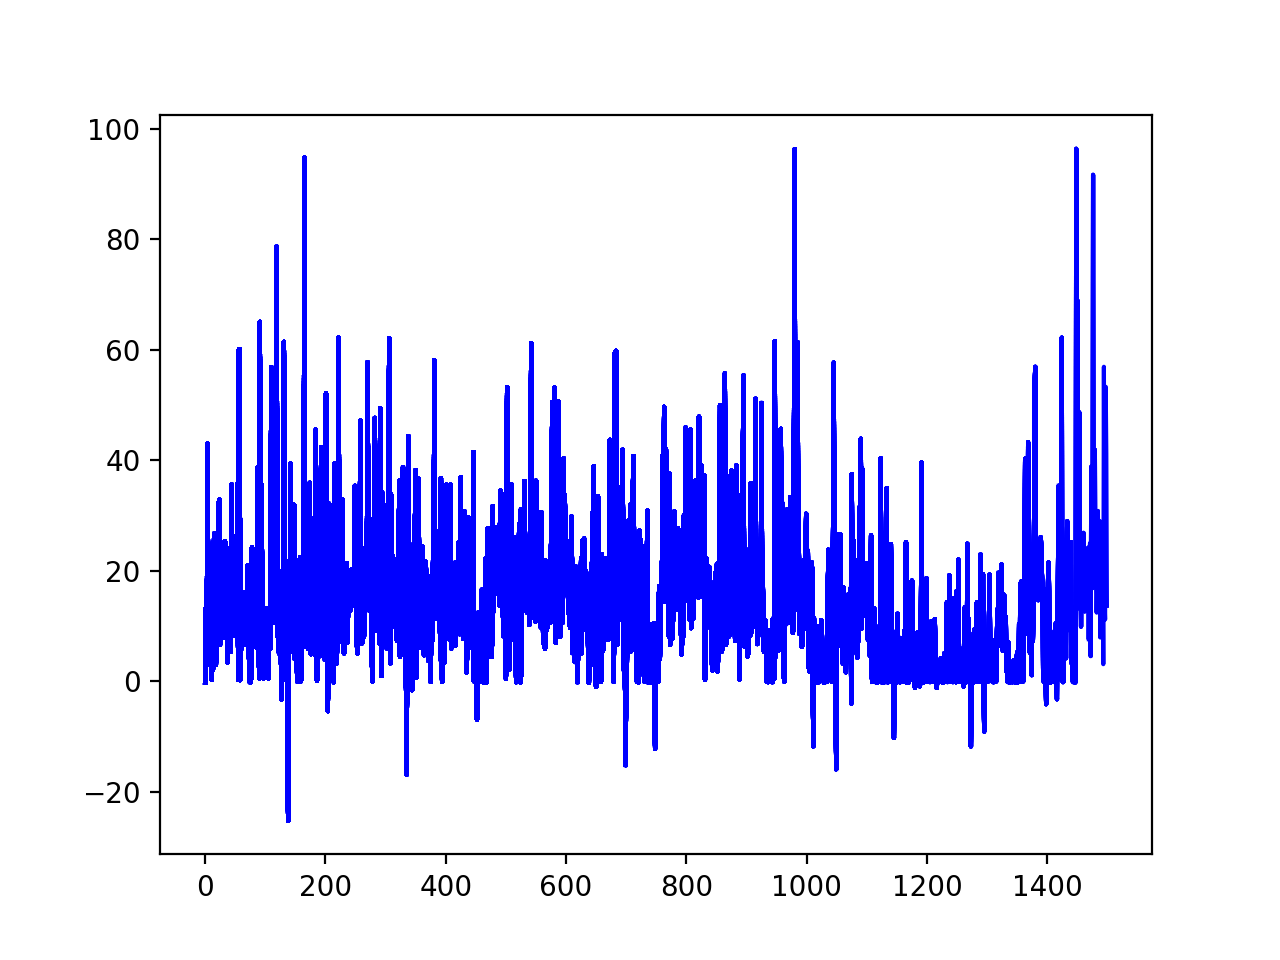

Episode Count:  0 	 Cumulative Reward:  -0.23900000000000055 	 eps:  0.98901
Episode Count:  1 	 Cumulative Reward:  13.173 	 eps:  0.98802099
Episode Count:  2 	 Cumulative Reward:  2.8759999999999994 	 eps:  0.98703296901
Episode Count:  3 	 Cumulative Reward:  7.936000000000002 	 eps:  0.98604593604099
Episode Count:  4 	 Cumulative Reward:  42.99 	 eps:  0.985059890104949
Episode Count:  5 	 Cumulative Reward:  18.188000000000002 	 eps:  0.984074830214844
Episode Count:  6 	 Cumulative Reward:  7.361 	 eps:  0.9830907553846291
Episode Count:  7 	 Cumulative Reward:  23.512999999999998 	 eps:  0.9821076646292445
Episode Count:  8 	 Cumulative Reward:  11.088 	 eps:  0.9811255569646152
Episode Count:  9 	 Cumulative Reward:  10.642 	 eps:  0.9801444314076506
Episode Count:  10 	 Cumulative Reward:  3.366000000000003 	 eps:  0.9791642869762429
Episode Count:  11 	 Cumulative Reward:  0.27599999999999775 	 eps:  0.9781851226892667
Episode Count:  12 	 Cumulative Reward:  23.98400000000

Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.3511
Episode Count:  72 	 Cumulative Reward:  10.382 	 eps:  0.9202712088024978
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.3407
Episode Count:  73 	 Cumulative Reward:  4.571000000000003 	 eps:  0.9193509375936953
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.3941
Episode Count:  74 	 Cumulative Reward:  -0.0930000000000018 	 eps:  0.9184315866561017
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.2483
Episode Count:  75 	 Cumulative Reward:  -0.21599999999999886 	 eps:  0.9175131550694456
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.3701
Episode Count:  76 	 Cumulative Reward:  8.13 	 eps:  0.9165956419143761
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.2191
Episode Count:  77 	 Cumulative Reward:  0.5699999999999997 	 eps:  0.9156790462724618
Epoch 1/1
512/512 [===

512/512 [==============================] - 3s 6ms/step - loss: 1.4135
Episode Count:  172 	 Cumulative Reward:  13.711999999999996 	 eps:  0.8326541629393406
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.5044
Episode Count:  173 	 Cumulative Reward:  6.731000000000001 	 eps:  0.8318215087764013
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.3670
Episode Count:  174 	 Cumulative Reward:  35.888 	 eps:  0.8309896872676249
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.4070
Episode Count:  175 	 Cumulative Reward:  8.271 	 eps:  0.8301586975803573
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.4978
Episode Count:  176 	 Cumulative Reward:  4.899000000000003 	 eps:  0.8293285388827769
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.4619
Episode Count:  177 	 Cumulative Reward:  7.518999999999988 	 eps:  0.8284992103438942
Epoch 1/1
512/512 [===========

512/512 [==============================] - 3s 6ms/step - loss: 1.6084
Episode Count:  272 	 Cumulative Reward:  12.870000000000001 	 eps:  0.7533789478890544
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.4483
Episode Count:  273 	 Cumulative Reward:  15.563999999999997 	 eps:  0.7526255689411653
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.7280
Episode Count:  274 	 Cumulative Reward:  17.346000000000004 	 eps:  0.7518729433722241
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.8732
Episode Count:  275 	 Cumulative Reward:  20.732 	 eps:  0.7511210704288519
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.5560
Episode Count:  276 	 Cumulative Reward:  29.261 	 eps:  0.750369949358423
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.6317
Episode Count:  277 	 Cumulative Reward:  5.862 	 eps:  0.7496195794090647
Epoch 1/1
512/512 [=====================

Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.8833
Episode Count:  323 	 Cumulative Reward:  36.309000000000005 	 eps:  0.715901677101829
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.7377
Episode Count:  324 	 Cumulative Reward:  4.491000000000001 	 eps:  0.7151857754247272
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.7985
Episode Count:  325 	 Cumulative Reward:  17.431 	 eps:  0.7144705896493024
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.9239
Episode Count:  326 	 Cumulative Reward:  7.865 	 eps:  0.7137561190596531
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.8404
Episode Count:  327 	 Cumulative Reward:  12.756000000000002 	 eps:  0.7130423629405934
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.0698
Episode Count:  328 	 Cumulative Reward:  35.19 	 eps:  0.7123293205776529
Epoch 1/1
512/512 [=============

Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.1341
Episode Count:  423 	 Cumulative Reward:  8.537 	 eps:  0.6477422155472693
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.3159
Episode Count:  424 	 Cumulative Reward:  16.386000000000003 	 eps:  0.647094473331722
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.4533
Episode Count:  425 	 Cumulative Reward:  36.92500000000001 	 eps:  0.6464473788583902
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.8625
Episode Count:  426 	 Cumulative Reward:  11.462000000000002 	 eps:  0.6458009314795318
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.2901
Episode Count:  427 	 Cumulative Reward:  14.782 	 eps:  0.6451551305480523
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.2928
Episode Count:  428 	 Cumulative Reward:  18.704 	 eps:  0.6445099754175042
Epoch 1/1
512/512 [============

Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.6043
Episode Count:  473 	 Cumulative Reward:  8.737 	 eps:  0.6161360410493769
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.7223
Episode Count:  474 	 Cumulative Reward:  7.345000000000002 	 eps:  0.6155199050083275
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.6575
Episode Count:  475 	 Cumulative Reward:  6.032000000000001 	 eps:  0.6149043851033192
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.7237
Episode Count:  476 	 Cumulative Reward:  4.390999999999998 	 eps:  0.6142894807182159
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.7670
Episode Count:  477 	 Cumulative Reward:  6.932000000000002 	 eps:  0.6136751912374977
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.7877
Episode Count:  478 	 Cumulative Reward:  31.677999999999997 	 eps:  0.6130615160462602
Epoch 1/1

Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.1612
Episode Count:  523 	 Cumulative Reward:  13.854999999999997 	 eps:  0.5860720699812046
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.6639
Episode Count:  524 	 Cumulative Reward:  -0.18299999999999744 	 eps:  0.5854859979112235
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.7714
Episode Count:  525 	 Cumulative Reward:  31.096000000000004 	 eps:  0.5849005119133123
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.1250
Episode Count:  526 	 Cumulative Reward:  1.1220000000000003 	 eps:  0.584315611401399
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.6290
Episode Count:  527 	 Cumulative Reward:  22.376000000000005 	 eps:  0.5837312957899976
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 1.8060
Episode Count:  528 	 Cumulative Reward:  19.326000000000004 	 eps:  0.58314756

Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.0903
Episode Count:  573 	 Cumulative Reward:  13.134000000000002 	 eps:  0.5574750514952064
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.1787
Episode Count:  574 	 Cumulative Reward:  10.615000000000006 	 eps:  0.5569175764437112
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.7008
Episode Count:  575 	 Cumulative Reward:  24.105999999999998 	 eps:  0.5563606588672675
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.1221
Episode Count:  576 	 Cumulative Reward:  31.39 	 eps:  0.5558042982084003
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.4161
Episode Count:  577 	 Cumulative Reward:  50.525000000000006 	 eps:  0.5552484939101918
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.2203
Episode Count:  578 	 Cumulative Reward:  20.008000000000003 	 eps:  0.5546932454162816
Epoch

Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.1802
Episode Count:  673 	 Cumulative Reward:  43.69199999999999 	 eps:  0.5043990488046737
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.9894
Episode Count:  674 	 Cumulative Reward:  16.657000000000004 	 eps:  0.503894649755869
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.9212
Episode Count:  675 	 Cumulative Reward:  13.871000000000006 	 eps:  0.5033907551061131
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.5878
Episode Count:  676 	 Cumulative Reward:  13.992000000000003 	 eps:  0.502887364351007
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.7434
Episode Count:  677 	 Cumulative Reward:  39.12500000000001 	 eps:  0.502384476986656
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.0359
Episode Count:  678 	 Cumulative Reward:  19.516 	 eps:  0.5018820925096693
Epoch 1/1

Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.8029
Episode Count:  723 	 Cumulative Reward:  14.044999999999995 	 eps:  0.4797872140802346
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.4675
Episode Count:  724 	 Cumulative Reward:  25.573 	 eps:  0.4793074268661544
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.7534
Episode Count:  725 	 Cumulative Reward:  7.6659999999999995 	 eps:  0.47882811943928827
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.8644
Episode Count:  726 	 Cumulative Reward:  10.004999999999999 	 eps:  0.478349291319849
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.3336
Episode Count:  727 	 Cumulative Reward:  17.653 	 eps:  0.47787094202852914
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.6105
Episode Count:  728 	 Cumulative Reward:  24.452 	 eps:  0.47739307108650064
Epoch 1/1
512/512 [=======

Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.2253
Episode Count:  773 	 Cumulative Reward:  6.627999999999999 	 eps:  0.45637629837009325
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.5345
Episode Count:  774 	 Cumulative Reward:  10.15 	 eps:  0.45591992207172316
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.1540
Episode Count:  775 	 Cumulative Reward:  16.55 	 eps:  0.45546400214965144
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.1800
Episode Count:  776 	 Cumulative Reward:  26.714999999999996 	 eps:  0.4550085381475018
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.9973
Episode Count:  777 	 Cumulative Reward:  7.732000000000003 	 eps:  0.4545535296093543
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.8905
Episode Count:  778 	 Cumulative Reward:  18.488000000000003 	 eps:  0.4540989760797449
Epoch 1/1
512/512

Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.1229
Episode Count:  823 	 Cumulative Reward:  18.504999999999995 	 eps:  0.43410770358536055
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.0489
Episode Count:  824 	 Cumulative Reward:  20.590000000000007 	 eps:  0.4336735958817752
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.2898
Episode Count:  825 	 Cumulative Reward:  39.04600000000001 	 eps:  0.4332399222858934
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.4488
Episode Count:  826 	 Cumulative Reward:  22.202 	 eps:  0.43280668236360753
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.4245
Episode Count:  827 	 Cumulative Reward:  15.366999999999999 	 eps:  0.4323738756812439
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.6301
Episode Count:  828 	 Cumulative Reward:  26.138 	 eps:  0.4319415018055627
Epoch 1/1
512/5

512/512 [==============================] - 3s 5ms/step - loss: 4.2343
Episode Count:  923 	 Cumulative Reward:  20.085000000000004 	 eps:  0.39277724120559987
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.8907
Episode Count:  924 	 Cumulative Reward:  15.939000000000004 	 eps:  0.39238446396439425
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.7768
Episode Count:  925 	 Cumulative Reward:  50.346000000000004 	 eps:  0.39199207950042986
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.8853
Episode Count:  926 	 Cumulative Reward:  9.330999999999998 	 eps:  0.39160008742092944
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.2316
Episode Count:  927 	 Cumulative Reward:  19.455 	 eps:  0.3912084873335085
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.9126
Episode Count:  928 	 Cumulative Reward:  7.897000000000004 	 eps:  0.390817278846175
Epoch 1/1
512

Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 4.5081
Episode Count:  973 	 Cumulative Reward:  33.323 	 eps:  0.37361192246246955
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 4.0295
Episode Count:  974 	 Cumulative Reward:  10.578 	 eps:  0.37323831054000706
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 4.1355
Episode Count:  975 	 Cumulative Reward:  22.558000000000003 	 eps:  0.3728650722294671
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.8664
Episode Count:  976 	 Cumulative Reward:  26.579 	 eps:  0.37249220715723763
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.7310
Episode Count:  977 	 Cumulative Reward:  8.777000000000005 	 eps:  0.3721197149500804
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.6615
Episode Count:  978 	 Cumulative Reward:  9.984000000000002 	 eps:  0.3717475952351303
Epoch 1/1
512/512 [========

Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.3456
Episode Count:  1023 	 Cumulative Reward:  2.1580000000000004 	 eps:  0.35538176340781413
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.2769
Episode Count:  1024 	 Cumulative Reward:  11.027 	 eps:  0.3550263816444063
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.7768
Episode Count:  1025 	 Cumulative Reward:  10.589999999999996 	 eps:  0.3546713552627619
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.4397
Episode Count:  1026 	 Cumulative Reward:  3.187000000000002 	 eps:  0.35431668390749915
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.7811
Episode Count:  1027 	 Cumulative Reward:  3.0629999999999993 	 eps:  0.35396236722359165
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.4597
Episode Count:  1028 	 Cumulative Reward:  6.2429999999999986 	 eps:  0.3536084048563

512/512 [==============================] - 3s 6ms/step - loss: 4.0813
Episode Count:  1121 	 Cumulative Reward:  9.04 	 eps:  0.3221906879440124
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.8967
Episode Count:  1122 	 Cumulative Reward:  -0.0839999999999972 	 eps:  0.32186849725606836
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.4852
Episode Count:  1123 	 Cumulative Reward:  40.346000000000004 	 eps:  0.3215466287588123
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.2355
Episode Count:  1124 	 Cumulative Reward:  14.352999999999996 	 eps:  0.32122508213005346
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.8320
Episode Count:  1125 	 Cumulative Reward:  13.734 	 eps:  0.3209038570479234
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.7313
Episode Count:  1126 	 Cumulative Reward:  -0.28500000000000236 	 eps:  0.3205829531908755
Epoch 1/1
512/512

Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.9322
Episode Count:  1170 	 Cumulative Reward:  12.494000000000002 	 eps:  0.306776372097115
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.0180
Episode Count:  1171 	 Cumulative Reward:  5.263999999999999 	 eps:  0.30646959572501786
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.9173
Episode Count:  1172 	 Cumulative Reward:  7.205 	 eps:  0.30616312612929286
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.1495
Episode Count:  1173 	 Cumulative Reward:  12.072000000000003 	 eps:  0.30585696300316356
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.3052
Episode Count:  1174 	 Cumulative Reward:  15.227000000000002 	 eps:  0.3055511060401604
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.4617
Episode Count:  1175 	 Cumulative Reward:  18.215 	 eps:  0.30524555493412026
Epoch 1/1

Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.7727
Episode Count:  1219 	 Cumulative Reward:  3.509999999999998 	 eps:  0.2920995112478903
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.4574
Episode Count:  1220 	 Cumulative Reward:  -0.03300000000000219 	 eps:  0.29180741173664243
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.3050
Episode Count:  1221 	 Cumulative Reward:  0.3839999999999982 	 eps:  0.2915156043249058
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.5264
Episode Count:  1222 	 Cumulative Reward:  2.7180000000000026 	 eps:  0.2912240887205809
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.2461
Episode Count:  1223 	 Cumulative Reward:  4.157 	 eps:  0.29093286463186036
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.2795
Episode Count:  1224 	 Cumulative Reward:  -0.04500000000000178 	 eps:  0.29064193176

Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.7101
Episode Count:  1268 	 Cumulative Reward:  1.522000000000003 	 eps:  0.2781248239165119
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.6373
Episode Count:  1269 	 Cumulative Reward:  11.260000000000002 	 eps:  0.27784669909259535
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.8359
Episode Count:  1270 	 Cumulative Reward:  6.645000000000001 	 eps:  0.27756885239350276
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.7276
Episode Count:  1271 	 Cumulative Reward:  5.390000000000002 	 eps:  0.27729128354110927
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.0918
Episode Count:  1272 	 Cumulative Reward:  0.07499999999999589 	 eps:  0.2770139922575682
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.0673
Episode Count:  1273 	 Cumulative Reward:  -11.797 	 eps:  0.2767369782653

Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.3467
Episode Count:  1317 	 Cumulative Reward:  13.04 	 eps:  0.26481871656726186
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.3393
Episode Count:  1318 	 Cumulative Reward:  8.932 	 eps:  0.2645538978506946
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.1561
Episode Count:  1319 	 Cumulative Reward:  19.621000000000002 	 eps:  0.2642893439528439
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.2737
Episode Count:  1320 	 Cumulative Reward:  6.401000000000003 	 eps:  0.2640250546088911
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.1847
Episode Count:  1321 	 Cumulative Reward:  9.279 	 eps:  0.2637610295542822
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.0941
Episode Count:  1322 	 Cumulative Reward:  11.389999999999999 	 eps:  0.26349726852472793
Epoch 1/1
512/512 [=====

512/512 [==============================] - 3s 5ms/step - loss: 1.4905
Episode Count:  1415 	 Cumulative Reward:  -0.032000000000005385 	 eps:  0.24008582672641576
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.4376
Episode Count:  1416 	 Cumulative Reward:  -3.2650000000000015 	 eps:  0.23984574089968935
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.0964
Episode Count:  1417 	 Cumulative Reward:  12.974000000000002 	 eps:  0.23960589515878966
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.1840
Episode Count:  1418 	 Cumulative Reward:  24.635 	 eps:  0.23936628926363088
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 1.6047
Episode Count:  1419 	 Cumulative Reward:  35.369 	 eps:  0.23912692297436725
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.0095
Episode Count:  1420 	 Cumulative Reward:  7.158999999999998 	 eps:  0.23888779605139288
Epoch 1/1
5

Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 2.7750
Episode Count:  1465 	 Cumulative Reward:  23.734 	 eps:  0.22837098963250393
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.4702
Episode Count:  1466 	 Cumulative Reward:  14.472000000000003 	 eps:  0.22814261864287144
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.8524
Episode Count:  1467 	 Cumulative Reward:  21.738 	 eps:  0.22791447602422857
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.5049
Episode Count:  1468 	 Cumulative Reward:  24.168999999999993 	 eps:  0.22768656154820435
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 3.1440
Episode Count:  1469 	 Cumulative Reward:  7.598000000000002 	 eps:  0.22745887498665615
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 2.8544
Episode Count:  1470 	 Cumulative Reward:  18.988 	 eps:  0.2272314161116695
Epoch 1/1
512/512 

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [10]:
train_agent(contd = True,
            verbose=True, 
            num_episodes=4000,
            discount = 0.99, 
            batch_size = 512, 
            N = 100, # how often to clone the target policy
            memory_size = 2048,
            eps_decay_rate=0.999,
            max_exp_rate=0.2, 
            min_exp_rate=0.05)

In [11]:
# import matplotlib.pyplot as plt
# print(lmao[10][0][0].shape)
# f = lmao[10][0][0].transpose((2, 0, 1))
# f.shape

In [ ]:
plt.imshow(f[0])